# Forecasting metrics: case 1

In this notebooks forecast metrics for all models fitted for the simulation case 1 are calculated and saved to a single file.

In [121]:
import os
import sys
import pickle

import tensorflow as tf
import pandas as pd

src_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(src_path)

from Metrics.metrics import get_model_metrics
from DataSimulation.utils import plot_fit
from Transformers.model import Forecaster


## Data

In [122]:
case_path = os.path.join(src_path, "Notebooks", "data_generation_and_models_fitting", "case_1")

In [123]:
data = pd.read_csv(os.path.join(case_path, 'data.csv'), header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,11.0,4.0,43.0,31.0,15.0,3.0,56.0,7.0,322.0
1,35.0,7.0,4.0,14.0,26.0,13.0,0.0,51.0,4.0,232.0
2,10.0,4.0,5.0,9.0,43.0,44.0,4.0,39.0,3.0,416.0
3,33.0,7.0,4.0,23.0,13.0,33.0,0.0,38.0,11.0,912.0
4,4.0,4.0,4.0,17.0,16.0,21.0,2.0,52.0,14.0,3409.0


In [124]:
test_size = 12
train_data = data.iloc[:-test_size, :].to_numpy()
test_data = data.iloc[-test_size:, :].to_numpy()
print(train_data.shape)
print(test_data.shape)

(188, 10)
(12, 10)


In [125]:
metrics = {}
metrics_statistics = {}

## Sarima model

In [126]:
with open(os.path.join(case_path, "sarima.pkl"), "rb") as file:
    sarima_model = pickle.load(file)

In [127]:
sarima_prediction = sarima_model.predict(12)

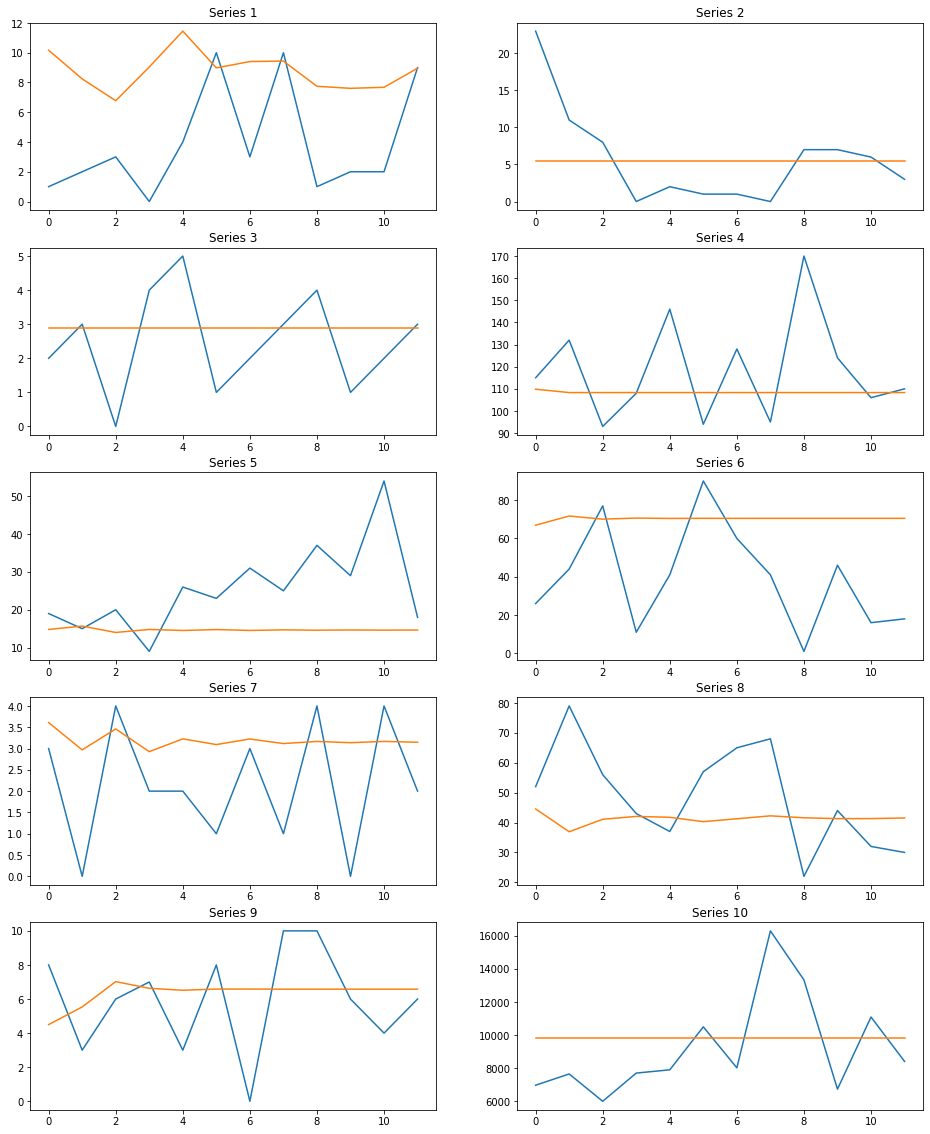

In [128]:
plot_fit(test_data, sarima_prediction, predicted=True, cols=2)

In [129]:
sarima_metrics, sarima_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=sarima_prediction,
    train_data=train_data,
    m=1,
    model_name="sarima",
    case="case_1"
)

In [130]:
metrics.update(sarima_metrics)
metrics_statistics.update(sarima_statistics)

## Poisson Autoregression model

In [131]:
with open(os.path.join(case_path, "poisson_autoregression.pkl"), "rb") as file:
    poisson_ar_model = pickle.load(file)

In [132]:
poisson_ar_prediction = poisson_ar_model.predict(12)

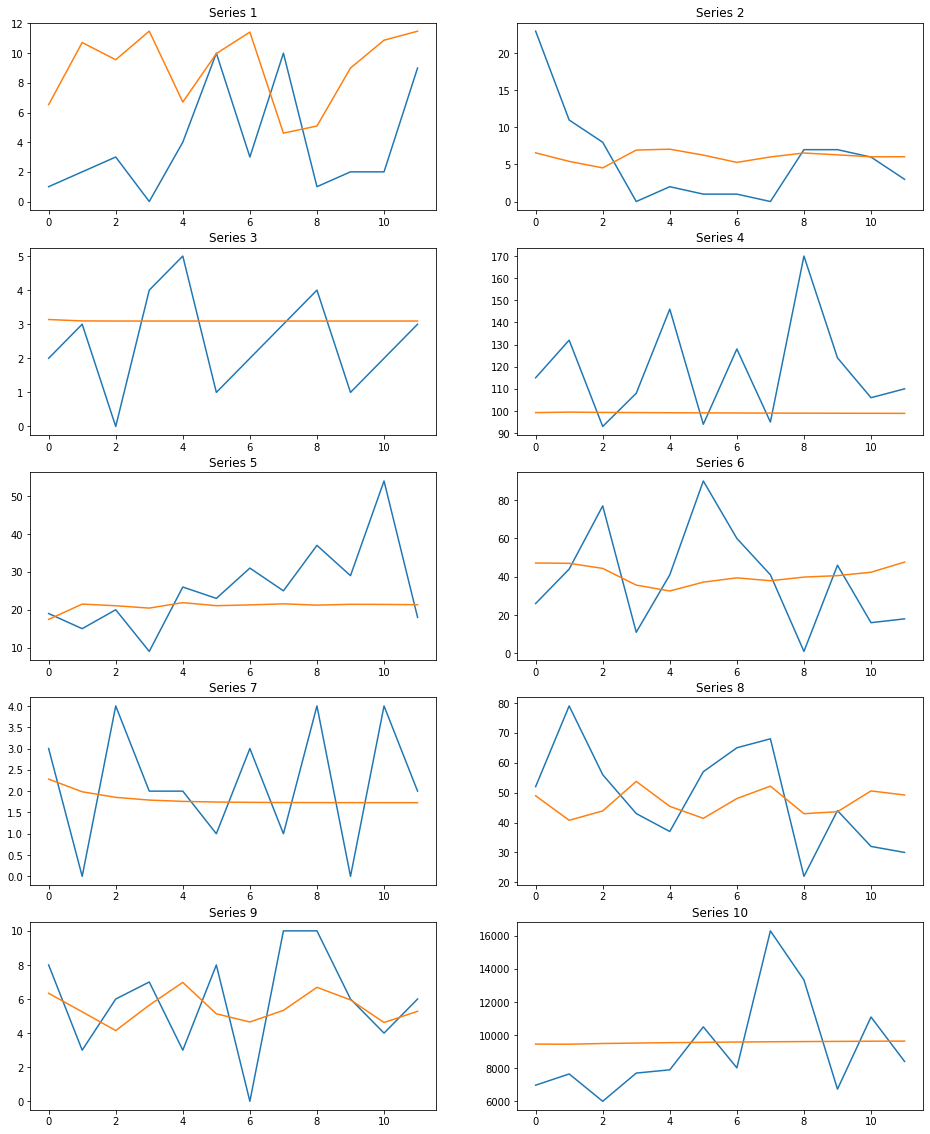

In [133]:
plot_fit(test_data, poisson_ar_prediction, predicted=True, cols=2)

In [134]:
p_ar_metrics, p_ar_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=poisson_ar_prediction,
    train_data=train_data,
    m=1,
    model_name="poisson_autorregression",
    case="case_1"
)

In [135]:
metrics.update(p_ar_metrics)
metrics_statistics.update(p_ar_statistics)

## Recurrent Neural Network

The model summary in the "rnn_fit.ipynb" allows to know that the best model uses a 24 timesteps input

In [136]:
with open(os.path.join(case_path, "rnn_scaler.pkl"), "rb") as file:
    rnn_scaler = pickle.load(file)

In [137]:
scaled_data = rnn_scaler.transform(train_data[-24:]).reshape((1,24,-1))

In [138]:
rnn_model = tf.keras.models.load_model(os.path.join(case_path, "rnn.h5"))

In [139]:
rnn_prediction = rnn_model.predict(scaled_data)

1/1 [==============================] - 1s 1s/step


In [140]:
rnn_prediction = rnn_scaler.inverse_transform(rnn_prediction[0])

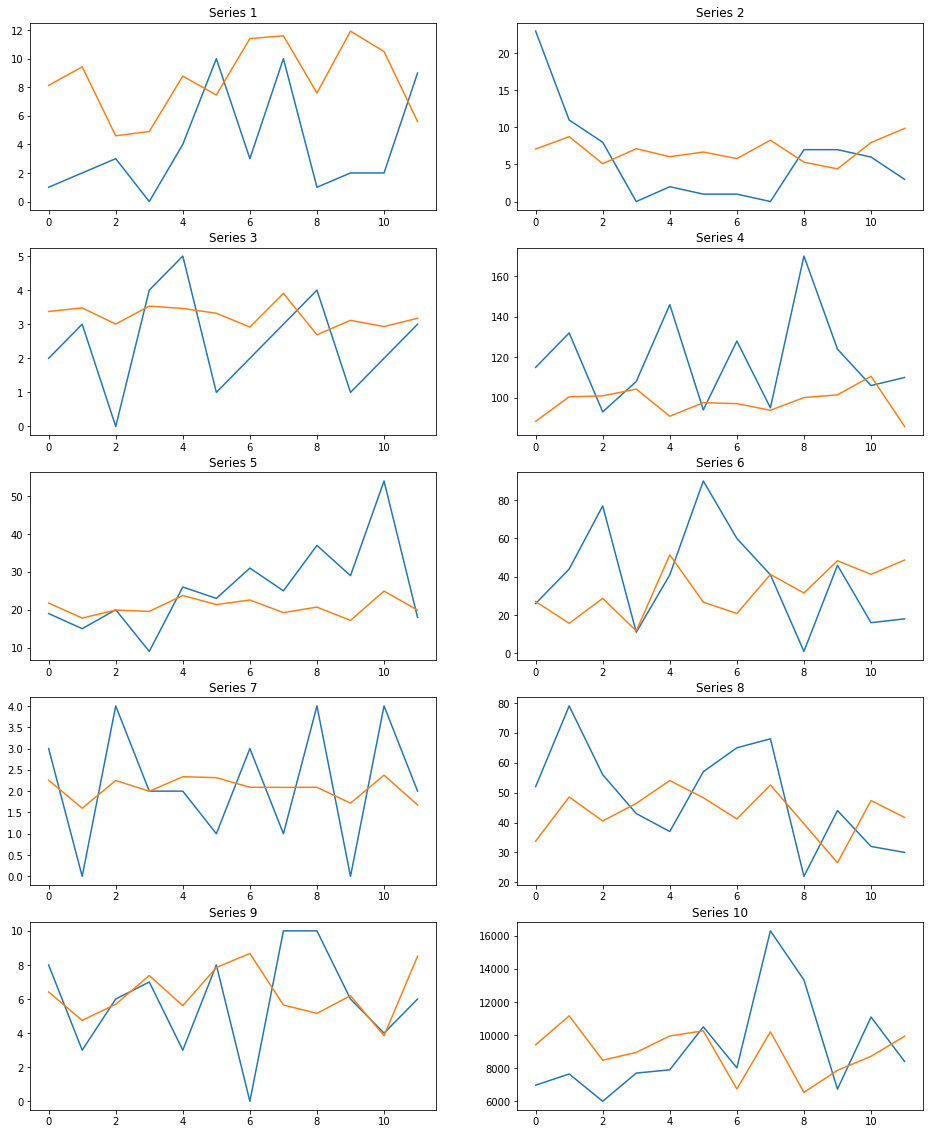

In [141]:
plot_fit(test_data, rnn_prediction, predicted=True, cols=2)

In [142]:
rnn_metrics, rnn_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=rnn_prediction,
    train_data=train_data,
    m=1,
    model_name="recurrent_neural_network",
    case="case_1"
)

In [143]:
metrics.update(rnn_metrics)
metrics_statistics.update(rnn_statistics)

## Transformer model

In [144]:
with open(os.path.join(case_path, "transformer_scaler.pkl"), "rb") as file:
    transformer_scaler = pickle.load(file)

In [145]:
transformer_model = tf.keras.models.load_model(os.path.join(case_path, "transformer.tf"))

In [146]:
forecaster = Forecaster(transformer_scaler, transformer_model)

In [147]:
inputs = train_data[-12:]

In [148]:
transformer_prediction = forecaster(inputs=inputs, steps=12)

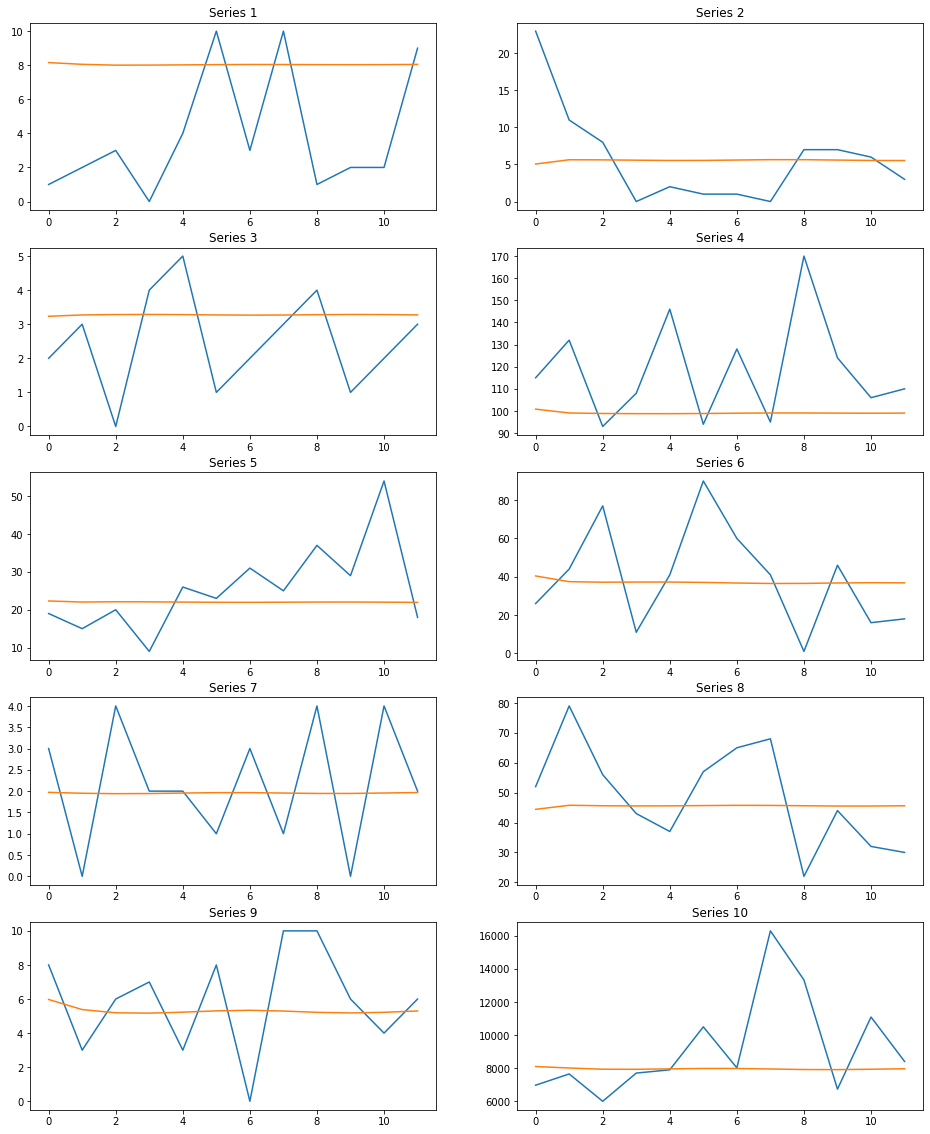

In [149]:
plot_fit(test_data, transformer_prediction, predicted=True, cols=2)

In [150]:
transformer_metrics, transformer_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=transformer_prediction,
    train_data=train_data,
    m=1,
    model_name="transformer",
    case="case_1"
)

In [151]:
metrics.update(transformer_metrics)
metrics_statistics.update(transformer_statistics)

## Metrics results

In [152]:
pd.DataFrame(metrics)

sarima-case_1           poisson_autorregression-case_1            \
          sMAPE      MASE                          sMAPE      MASE   
0     97.360461  0.562209                     104.455245  0.649179   
1     92.636967  0.753149                      92.701901  0.784342   
2     52.754032  0.647379                      53.520650  0.675473   
3     14.574494  0.610511                      18.637420  0.759695   
4     52.148480  0.989803                      32.705302  0.687007   
5     76.555681  1.310066                      63.552827  0.821873   
6     68.406752  0.681249                      71.541004  0.596303   
7     32.032295  0.542025                      31.985463  0.543960   
8     48.299101  0.407554                      48.974311  0.386338   
9     27.058533  0.724709                      25.913718  0.693230   

  recurrent_neural_network-case_1           transformer-case_1            
                            sMAPE      MASE              sMAPE      MASE  
0                      103.531836  0.608534          98.066696  0.539660  
1                       97.502505  0.877689          92.535452  0.757922  
2                       55.922934  0.718582          55.310037  0.720992  
3                       20.407752  0.816575          18.537435  0.756239  
4                       30.845610  0.647603          33.193442  0.697170  
5                       66.522265  0.864188          62.523086  0.789198  
6                       68.084325  0.545077          68.887329  0.579634  
7                       36.027966  0.587910          30.117430  0.511748  
8                       41.773516  0.379648          50.225285  0.407525  
9                       27.509238  0.727293          21.124309  0.578340

In [153]:
pd.DataFrame(metrics_statistics)

sarima           poisson_autorregression            \
                 sMAPE      MASE                   sMAPE      MASE   
case_1 mean  56.182680  0.722865               54.398784  0.659740   
       sd    26.157009  0.243920               27.283446  0.120916   
       min   14.574494  0.407554               18.637420  0.386338   
       max   97.360461  1.310066              104.455245  0.821873   

            recurrent_neural_network           transformer            
                               sMAPE      MASE       sMAPE      MASE  
case_1 mean                54.812795  0.677310   53.052050  0.633843  
       sd                  27.453495  0.147772   26.589102  0.121299  
       min                 20.407752  0.379648   18.537435  0.407525  
       max                103.531836  0.877689   98.066696  0.789198

In [154]:
with open("metrics.pkl", "wb") as outfile:
    pickle.dump(metrics, outfile)

In [155]:
with open("statistics.pkl", "wb") as outfile:
    pickle.dump(metrics_statistics, outfile)